In [1]:
!pip install XGBoost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install seaborn==0.9.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('s3://partly-cloudy-ml-inputs/MIAMI_every_6_hour_flat.csv')
df.head()

,localDateTime,Nx,Ny,Lat,Lon,geoEncode,NAME,iSSRs200430,iSSRs300430,meanTemp200430,meanTemp300430,meanRH_ice200430,meanRH_ice300430
0,2020-06-01 00:00:00,233,33,24.921705,-81.27609,dhqjy,MIAMI,0,0,241.380000,228.127833,81.680833,73.265000
1,2020-10-04 18:00:00,233,33,24.921705,-81.27609,dhqjy,MIAMI,1,1,243.788250,230.275333,33.925833,58.361667
2,2020-10-23 18:00:00,233,33,24.921705,-81.27609,dhqjy,MIAMI,0,0,241.995833,228.875167,49.405833,52.705000
3,2020-11-05 12:00:00,233,33,24.921705,-81.27609,dhqjy,MIAMI,0,0,239.876000,227.803333,22.170833,39.806667
4,2020-12-12 12:00:00,233,33,24.921705,-81.27609,dhqjy,MIAMI,0,0,238.642750,225.028667,45.038333,66.601667


In [5]:
#Creating a subset of the dataframe - Going to just look at ISSRs at FL 300 to FL 370
df = df[['localDateTime', 'iSSRs300430','Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']]
df = df.rename(columns={'iSSRs300430': 'ISSRCount'})
df.head()

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
0,2020-06-01 00:00:00,0,233,33,228.127833,73.265000
1,2020-10-04 18:00:00,1,233,33,230.275333,58.361667
2,2020-10-23 18:00:00,0,233,33,228.875167,52.705000
3,2020-11-05 12:00:00,0,233,33,227.803333,39.806667
4,2020-12-12 12:00:00,0,233,33,225.028667,66.601667


In [6]:
#Convert variables into appropriate formats for analysis
#1. localDateTime -> Date object
df['localDateTime'] = pd.to_datetime(df['localDateTime'], infer_datetime_format=True)
#Check change has occured
#df.info()

In [7]:
#df.sort_values('localDateTime')

In [8]:
#test date is randomly picked - 2020/9/5
df = df[df.localDateTime <= '2020-09-06 00:00:00']
df = df[df.localDateTime >= '2020-08-05 00:00:00']
df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
18,2020-08-08 12:00:00,0,233,33,227.457333,75.756667
28,2020-08-05 12:00:00,1,233,33,229.426333,93.713333
34,2020-08-23 00:00:00,0,233,33,230.420333,53.445000
81,2020-08-09 06:00:00,0,233,33,227.131333,71.728333
93,2020-08-22 18:00:00,0,233,33,230.730000,41.231667
...,...,...,...,...,...,...
1190392,2020-08-21 12:00:00,0,248,62,228.455333,76.756667
1190401,2020-08-29 06:00:00,0,248,62,229.070833,95.258333
1190408,2020-08-15 00:00:00,0,248,62,228.161667,69.353333
1190409,2020-09-01 12:00:00,0,248,62,229.419000,68.548333


In [9]:
features = ['Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']
label = 'ISSRCount'
test_df = df[df.localDateTime >= '2020-09-05 00:00:00']
train_df = df[df.localDateTime < '2020-09-05 00:00:00']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [10]:
params = { 'max_depth': [3, 6, 10, 15],
           'learning_rate': [0.01, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0),
           'colsample_bylevel': np.arange(0.4, 1.0),
           'n_estimators': [100, 500]}

In [11]:
xgbr = xgb.XGBRegressor(seed = 20)

In [12]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         n_iter=25,
                         verbose=1)

In [13]:
reg = clf.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-mae:0.54483	validation_1-mae:0.53032
[1]	validation_0-mae:0.54195	validation_1-mae:0.52795
[2]	validation_0-mae:0.53910	validation_1-mae:0.52570
[3]	validation_0-mae:0.53630	validation_1-mae:0.52300
[4]	validation_0-mae:0.53347	validation_1-mae:0.52072
[5]	validation_0-mae:0.53075	validation_1-mae:0.51807
[6]	validation_0-mae:0.52801	validation_1-mae:0.51543
[7]	validation_0-mae:0.52530	validation_1-mae:0.51284
[8]	validation_0-mae:0.52179	validation_1-mae:0.50959
[9]	validation_0-mae:0.51914	validation_1-mae:0.50706
[10]	validation_0-mae:0.51651	validation_1-mae:0.50452
[11]	validation_0-mae:0.51392	validation_1-mae:0.50204
[12]	validation_0-mae:0.51133	validation_1-mae:0.49956
[13]	validation_0-mae:0.50878	validation_1-mae:0.49747
[14]	validation_0-mae:0.50544	validation_1-mae:0.49438
[15]	validation_0-mae:0.50292	validation_1-mae:0.49230
[16]	validation_0-mae:0.50044	validation_1-mae:0.48991
[17]	validati

In [40]:
print("Best parameters:", clf.best_params_)

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}


In [41]:
#print("Lowest RMSE:", (clf.best_score)**(1/2.0))

In [42]:
#reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
#reg.fit(X_train,
#        y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        eval_metric='mae')

In [43]:
y_pred = reg.predict(X_test)

In [44]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['y_pred'] = pd.Series(y_pred)

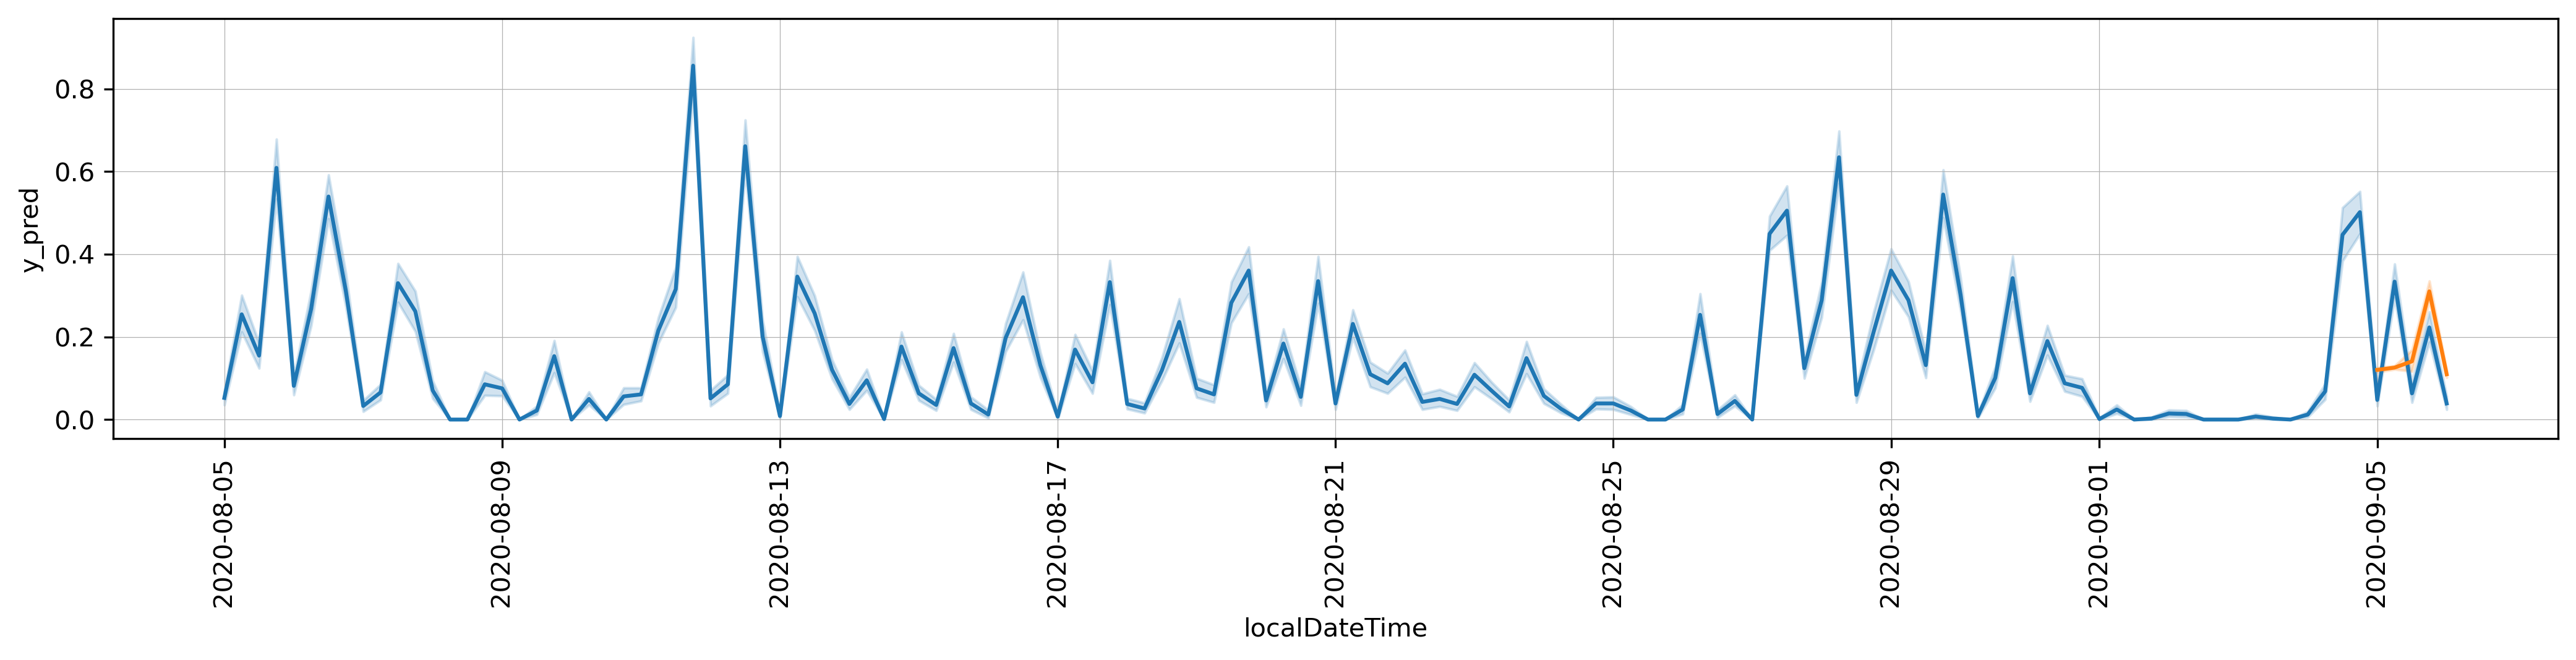

In [45]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=df, x='localDateTime',y='ISSRCount')
sns.lineplot(data=test_df, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [67]:
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-09-05 06:00:00,1,233,33,227.966167,81.796667,0.0
1,2020-09-05 18:00:00,0,233,33,228.182500,77.648333,0.0
2,2020-09-05 12:00:00,0,233,33,227.958833,83.706667,0.0
3,2020-09-06 00:00:00,0,233,33,228.387000,87.535000,0.0
4,2020-09-05 00:00:00,0,233,33,228.393667,87.408333,0.0
...,...,...,...,...,...,...,...
4100,2020-09-06 00:00:00,0,248,62,228.116167,60.843333,0.0
4101,2020-09-05 18:00:00,0,248,62,228.224167,81.523333,0.0
4102,2020-09-05 00:00:00,0,248,62,229.237167,63.861667,0.0
4103,2020-09-05 12:00:00,0,248,62,228.854667,72.693333,0.0


In [68]:
test_df['y_pred'] = round(test_df['y_pred'],0)
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-09-05 06:00:00,1,233,33,227.966167,81.796667,0.0
1,2020-09-05 18:00:00,0,233,33,228.182500,77.648333,0.0
2,2020-09-05 12:00:00,0,233,33,227.958833,83.706667,0.0
3,2020-09-06 00:00:00,0,233,33,228.387000,87.535000,0.0
4,2020-09-05 00:00:00,0,233,33,228.393667,87.408333,0.0
...,...,...,...,...,...,...,...
4100,2020-09-06 00:00:00,0,248,62,228.116167,60.843333,0.0
4101,2020-09-05 18:00:00,0,248,62,228.224167,81.523333,0.0
4102,2020-09-05 00:00:00,0,248,62,229.237167,63.861667,0.0
4103,2020-09-05 12:00:00,0,248,62,228.854667,72.693333,0.0


In [69]:
test_df['y_pred'].describe()

count    4105.000000
mean        0.065043
std         0.302542
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: y_pred, dtype: float64

In [70]:
test_df['ISSRCount'].describe()

count    4105.000000
mean        0.141291
std         0.440420
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ISSRCount, dtype: float64

In [71]:
test_df['localDateTime'] = pd.to_datetime(test_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts = test_df[['localDateTime', 'ISSRCount', 'y_pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='localDateTime').sum()

           localDateTime  ISSRCount  y_pred
0    2020-09-05 06:00:00          1     0.0
1    2020-09-05 18:00:00          0     0.0
2    2020-09-05 12:00:00          0     0.0
3    2020-09-06 00:00:00          0     0.0
4    2020-09-05 00:00:00          0     0.0
...                  ...        ...     ...
4100 2020-09-06 00:00:00          0     0.0
4101 2020-09-05 18:00:00          0     0.0
4102 2020-09-05 00:00:00          0     0.0
4103 2020-09-05 12:00:00          0     0.0
4104 2020-09-05 06:00:00          0     0.0

[4105 rows x 3 columns]


,ISSRCount,y_pred
localDateTime,,
2020-09-05,548,250.0
2020-09-06,32,17.0


In [72]:
#Examines sum of ISSRs in 6 hour time intervals
df_sum = df_ISSR_counts.resample('6H', on='localDateTime').sum()
df_sum

,ISSRCount,y_pred
localDateTime,,
2020-09-05 00:00:00,39,10.0
2020-09-05 06:00:00,274,4.0
2020-09-05 12:00:00,52,60.0
2020-09-05 18:00:00,183,176.0
2020-09-06 00:00:00,32,17.0


In [73]:
# convert the index to column
df_sum.reset_index(inplace=True)
df_sum

,localDateTime,ISSRCount,y_pred
0,2020-09-05 00:00:00,39,10.0
1,2020-09-05 06:00:00,274,4.0
2,2020-09-05 12:00:00,52,60.0
3,2020-09-05 18:00:00,183,176.0
4,2020-09-06 00:00:00,32,17.0


In [74]:
train_df['localDateTime'] = pd.to_datetime(train_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts_train = train_df[['localDateTime', 'ISSRCount']].copy()
print(df_ISSR_counts_train)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts_train.resample('D', on='localDateTime').sum()
df_sum_train = df_ISSR_counts_train.resample('6H', on='localDateTime').sum()

              localDateTime  ISSRCount
18      2020-08-08 12:00:00          0
28      2020-08-05 12:00:00          1
34      2020-08-23 00:00:00          0
81      2020-08-09 06:00:00          0
93      2020-08-22 18:00:00          0
...                     ...        ...
1190392 2020-08-21 12:00:00          0
1190401 2020-08-29 06:00:00          0
1190408 2020-08-15 00:00:00          0
1190409 2020-09-01 12:00:00          0
1190425 2020-09-02 12:00:00          0

[101804 rows x 2 columns]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [75]:
# convert the index to column
df_sum_train.reset_index(inplace=True)
df_sum_train

,localDateTime,ISSRCount
0,2020-08-05 00:00:00,43
1,2020-08-05 06:00:00,209
2,2020-08-05 12:00:00,127
3,2020-08-05 18:00:00,500
4,2020-08-06 00:00:00,67
...,...,...
119,2020-09-03 18:00:00,0
120,2020-09-04 00:00:00,10
121,2020-09-04 06:00:00,56
122,2020-09-04 12:00:00,367


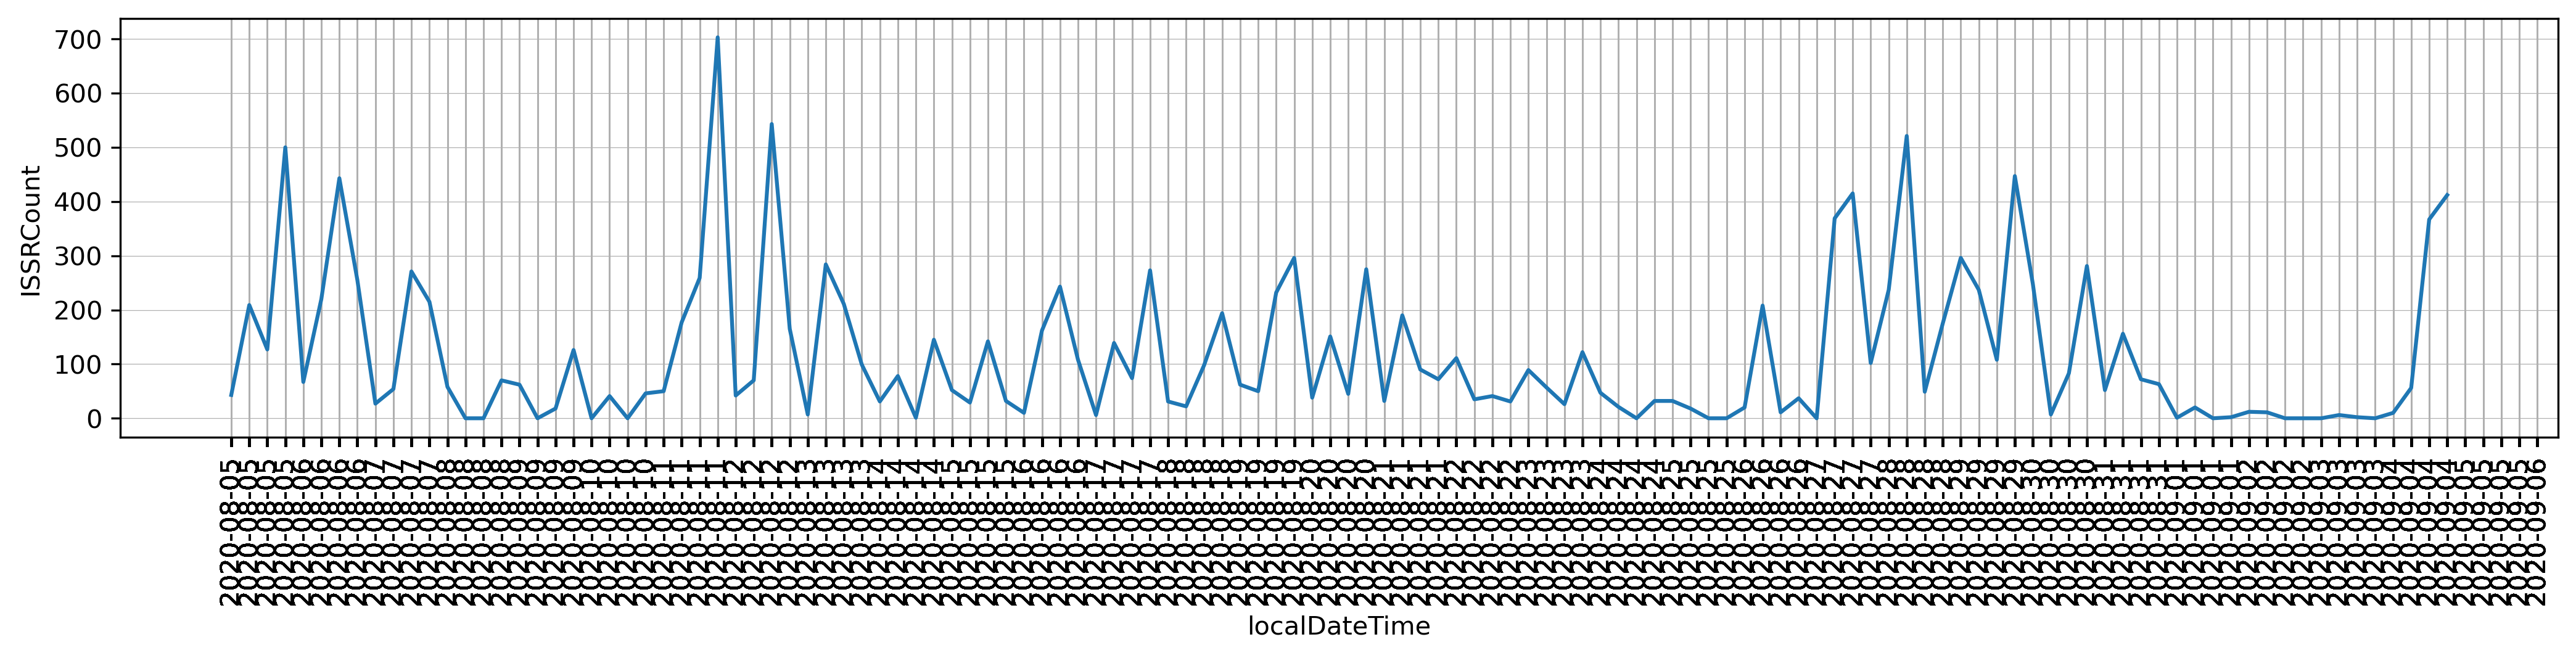

In [78]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=df_sum_train, x='localDateTime',y='ISSRCount')
#sns.lineplot(data=df_sum, x='localDateTime',y='y_pred')
ax.set(xticks=df.localDateTime.values)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

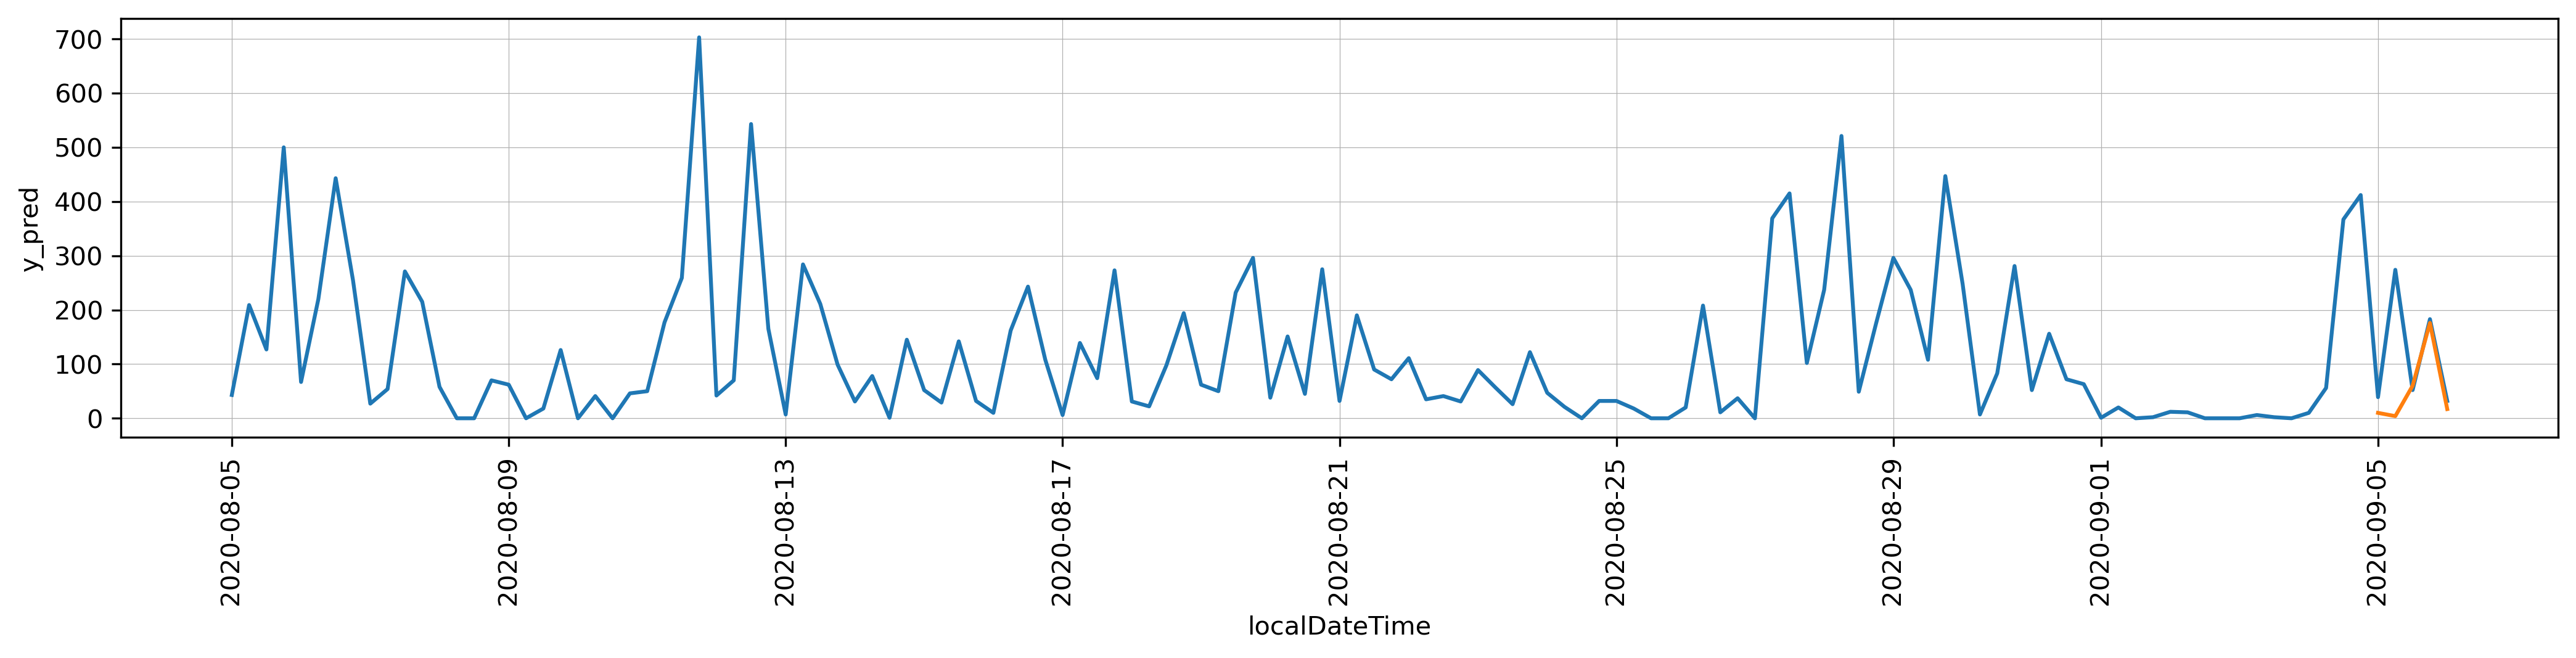

In [56]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=pd.concat([df_sum_train, df_sum]), x='localDateTime',y='ISSRCount')
sns.lineplot(data=df_sum, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [31]:
confusion_matrix = pd.crosstab(test_df['ISSRCount'], test_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0.0,1.0,2.0,3.0
Actual,,,,
0,3573,82,6,0
1,269,42,8,2
2,42,49,12,7
3,6,1,4,2


In [32]:
#from sklearn.metrics import plot_confusion_matrix
#disp = plot_confusion_matrix(reg, X_test, y_test,
#                           display_labels = label,
#                           cmap = plt.cm.Blues)
#plt.show()

In [33]:
# For predicted value 0:
TP=3575
TN=130  #=45+7+2+50+13+6+1+4+2
FP=314  #=267+41+6
FN=86   #=83+3+0

In [34]:
# true positive rate
TP_rate = TP/(TP+FN)
print("True positive: %.2f%%" % (TP_rate* 100.0))
#Specificity or true negative rate
TN_rate = TN/(TN+FP) 
print("True negative: %.2f%%" % (TN_rate* 100.0))
# Precision or positive predictive value
Precision_rate = TP/(TP+FP)
print("Precision: %.2f%%" % (Precision_rate* 100.0))
# Negative predictive value
#NP_rate = TN/(TN+FN)
#print("Negative predictive: %.2f%%" % (NP_rate * 100.0))
# Fall out or false positive rate
FP_rate = FP/(FP+TN)
print("False Positive: %.2f%%" % (FP_rate * 100.0))
# False negative rate
FN_rate = FN/(TP+FN)
print("False Negative: %.2f%%" % (FN_rate * 100.0))
# False discovery rate
#FDR = FP/(TP+FP)

True positive: 97.65%
True negative: 29.28%
Precision: 91.93%
False Positive: 70.72%
False Negative: 2.35%


In [35]:
from sklearn.metrics import accuracy_score

In [36]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.40%


In [39]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print('MAE: ', mae)

MAE:  0.1313032886723508
